In [1]:
from collections import defaultdict
import vmapper
import os
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.ops import transform, split
import shapely
from pyproj import Transformer, CRS, Proj

import matplotlib.pyplot as plt
import seaborn as sns

from catppuccin_palette import catppuccin as cpc
import mplcatppuccin
from mplcatppuccin.palette import load_color
from mplcatppuccin.colormaps import get_colormap_from_list
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
#from jinja2 import Environment, PackageLoader, select_autoescape
import jinja2
from tqdm.notebook import tqdm

/home/benny/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/geopandas/geodataframe.py:1805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[exploded_geom.name] = exploded_geom.values
/tmp/ipykernel_58164/2554561926.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf3['area'] = gdf3.area


<Axes: >

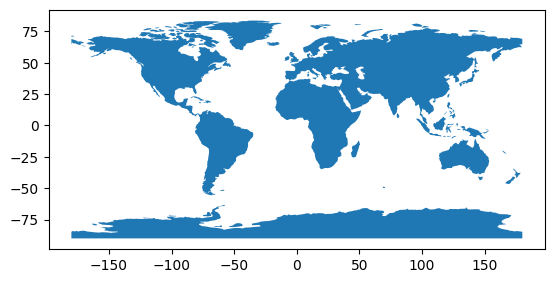

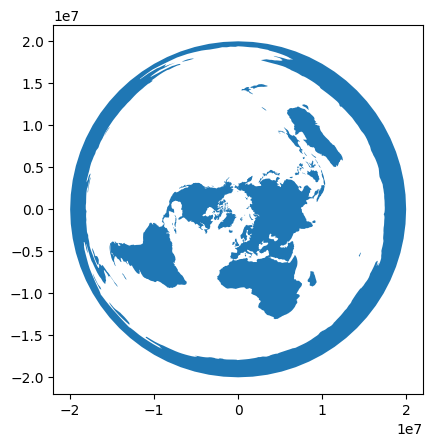

In [116]:
fp = '../data/natural_earth/ne_110m_admin_0_countries2.shp'
#fp = 'data/natural_earth/ne_110m_land.shp'
gdf = gpd.read_file(fp)
gdf2 = gdf.dissolve().explode(index_parts=True)
gdf3 = gdf2[['featurecla', 'geometry']].copy()
gdf3['area'] = gdf3.area
gdf4 = gdf3[gdf3['area']>1]
#gdf4 = gdf4.reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
gdf4.plot()
#gdf.plot()
this_crs = '+proj=aeqd +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs'  # UN logo
gdf4.to_crs(this_crs).plot()

In [3]:
projections = {}
ref_points = {}
#table_cells = defaultdict(list)
for i, x in enumerate([0, 60, 120, 180, -120, -60]):
    for j, y in enumerate([90-y*30 for y in range(7)]):
        x2 = 'E{}'.format(x) if x>0 else 'W{}'.format(abs(x)) if x<0 else 'EW{}'.format(x)
        y2 = 'N{}'.format(y) if y>0 else 'S{}'.format(abs(y)) if y<0 else 'NS{}'.format(y)
        n = '{}-{}'.format(y2, x2)
        #print(n)
        this_crs = '+proj=aeqd +lat_0={} +lon_0={} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs'.format(y, x)
        projections[n] = this_crs
        #table_cells[i].append(n)
        #print(this_crs)
        ref_points[n] = (x, y)
len(projections)#, table_cells


42

In [69]:
def splitting_poly(this_geom, this_line):
    split_polys = split(this_geom, this_line)
    split_polys = [p for p in split_polys.geoms]
    return split_polys

def for_lon_0(pt3_buf):
    pt3_buf = pt3_buf.rotate(90)
    g = pt3_buf.exterior.tolist()[0]
    pt3_buf_line = LineString(g)
    #cut_horizontal = LineString([(2.98e7, 0), (-2.98e7, 0)])
    cut_vertical = LineString([(0, 2.98e7), (0, -2.98e7)])
    #pt3_buf.plot(ax=ax)
    split_lines = split(pt3_buf_line, cut_vertical)
    split_lines = [p for p in split_lines.geoms]
    line0, line1 = split_lines
    line1xy = line1.xy
    line1b = LineString(list(zip(line1xy[0][1:-1], line1xy[1][1:-1])))
    return (line0, line1b)
    """
    line0, line1 = split_lines
    #print(len(split_polys))
    for i in range(len(this_gdf)):
        row = this_gdf.iloc[i]
        this_g = row['geometry']
        if this_g.intersects(pt3_buf):
            split_polys = splitting_poly(this_geom, this_line)
    """

10

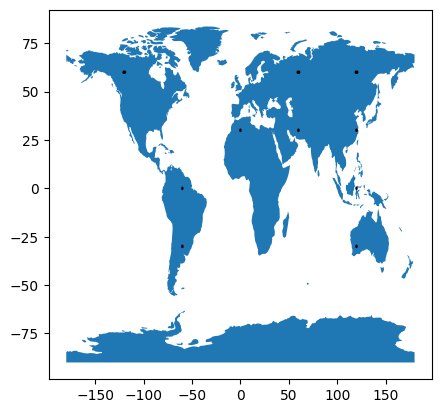

In [97]:

tmp = gdf4.copy()
split_geoms = {}
fig, ax = plt.subplots()
tmp.plot(ax=ax)

#k = 'N30-EW0'
#pt = ref_points[k]
for k, pt in ref_points.items():
    lon0, lat0 = pt
    this_crs = projections[k]

    if lon0==0 or abs(lat0)==90:# and abs(lat0)!=90:
        # can skip cause the other side do not cross land
        continue
        """
        line0, line1 = for_lon_0(pt3_buf)
        glines = gpd.GeoSeries([line0, line1], crs=this_crs)
        glines2 = glines.to_crs('epsg:4326')
        #print(glines2)
        #glines2.plot(ax=ax, ec='r')
        """
    else:
        pt2 = Point(lon0, lat0)
        pt2 = gpd.GeoSeries(pt2, crs='epsg:4326')
        pt3 = pt2.to_crs(this_crs)
        #print(pt3.x)
        pt3_buf = pt3.buffer(1.99e7)
        pt4_buf = pt3_buf.to_crs('epsg:4326')
        #print(tmp, pt4_buf)
        touched = False
        for g in tmp.geometry:
            if g.intersects(pt4_buf.iloc[0]):
                touched = True
        #if not(tmp.intersects(pt4_buf).any()):
        if not(touched):
            #pt4_buf.plot(ax=ax, fc='r')
            continue    
        pt4_buf.plot(ax=ax, fc='k')
        split_geoms[k] = pt4_buf
len(split_geoms)

<Axes: >

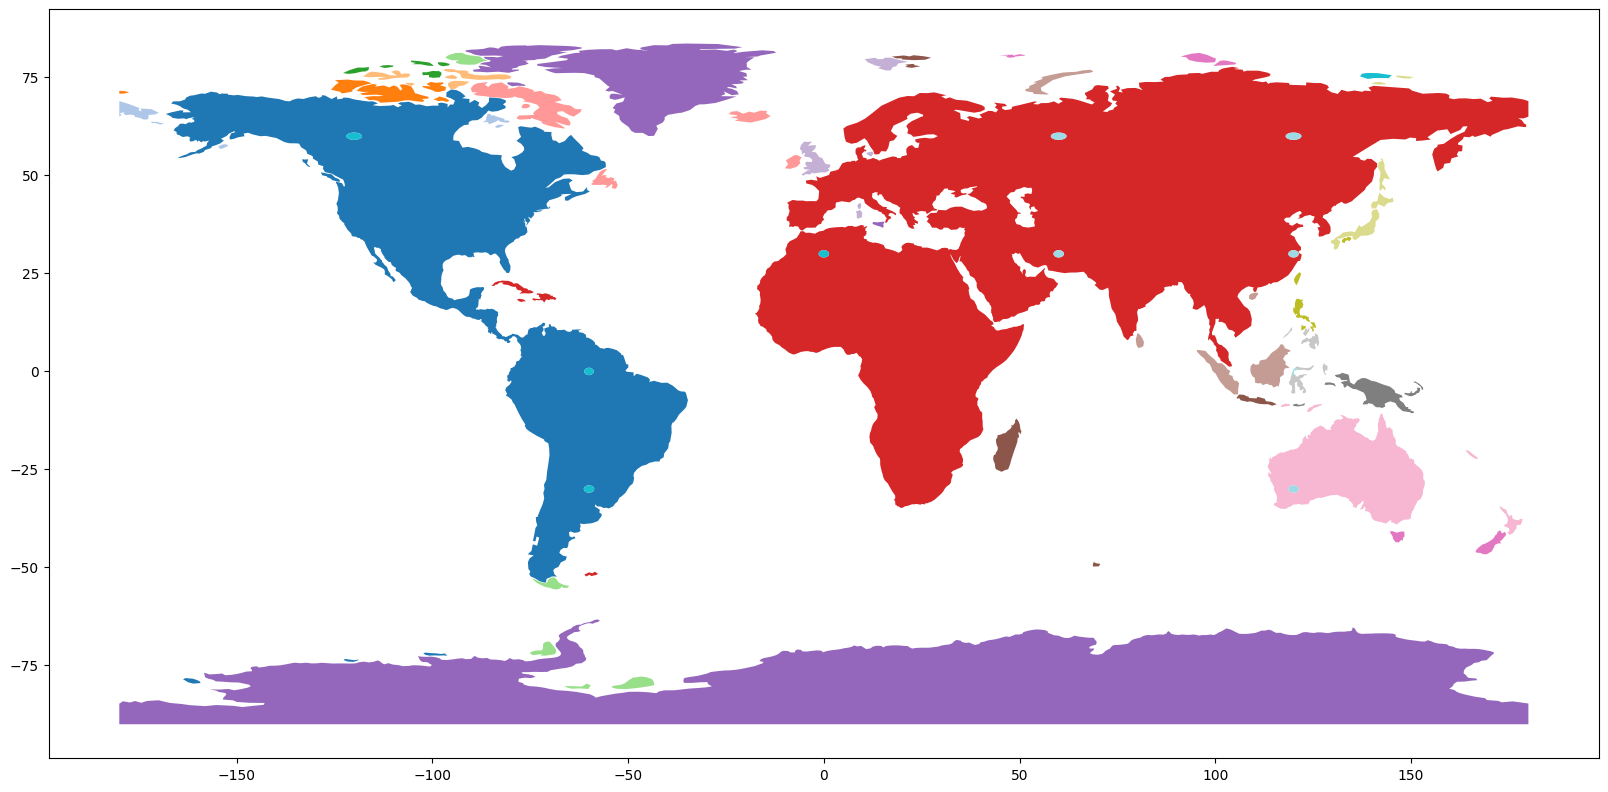

In [136]:

tmp = gdf4.copy()
#k = 'N30-E120'
#spg = split_geoms[k]
#fig, ax = plt.subplots()

for k, spg in split_geoms.items():
    #this_crs = projections[k]
    spg = gpd.GeoDataFrame(geometry=spg)
    #print(spg.head())
    tmp2 = tmp.overlay(spg, how='difference')
    #tmp2.plot(ax=ax, fc='grey')
    #print(tmp2)
    tmp3 = tmp.overlay(spg, how='intersection')
    #tmp3.plot(ax=ax, fc='r')
    #print(tmp3)
    alt_pt = sorted([p for p in tmp3.iloc[0].geometry.exterior.coords])[0]
    alx, aly = alt_pt
    tmp3['alt_x'] = alx
    tmp3['alt_y'] = aly
    tmp3['featurecla'] = 'cut'
    tmp3['ref_pt'] = k
    tmp = pd.concat([tmp2, tmp3])
#print(alt_pt)
tmp = tmp.reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
fig, ax = plt.subplots(figsize=(20, 10))
tmp.plot('id', cmap='tab20', ax=ax)

In [137]:
#tmp[tmp['featurecla']=='cut']#.plot('id', cmap='tab20')
gdf5 = tmp
gdf5.head()

,id,featurecla,geometry,area,alt_x,alt_y,ref_pt
0,0,Admin-0 country,"POLYGON ((-163.71290 -78.59567, -163.71290 -78...",3.716703,NaN,NaN,NaN
1,1,Admin-0 country,"POLYGON ((-122.40624 -73.32462, -121.21151 -73...",1.541898,NaN,NaN,NaN
2,2,Admin-0 country,"POLYGON ((-100.78346 -72.50162, -101.80187 -72...",3.004556,NaN,NaN,NaN
3,3,Admin-0 country,"POLYGON ((-79.12031 8.99609, -79.55788 8.93237...",4158.334445,NaN,NaN,NaN
4,4,Admin-0 country,"POLYGON ((-128.35841 50.77065, -127.30858 50.5...",4.056773,NaN,NaN,NaN


In [138]:
gdf5.to_file('../data/natural_earth/ne_110m_admin_0_countries2_azqd.shp')


In [139]:
gdf5[gdf5['featurecla']=='cut']

,id,featurecla,geometry,area,alt_x,alt_y,ref_pt
92,92,cut,"POLYGON ((-122.00942 60.07306, -121.98887 60.1...",4158.334445,-122.013335,59.988916,S60-E60
93,93,cut,"POLYGON ((-61.33404 -29.92769, -61.32146 -29.8...",4158.334445,-61.338557,-29.997474,N30-E120
94,94,cut,"POLYGON ((-61.23220 0.06263, -61.22279 0.12634...",4158.334445,-61.235258,0.000000,NS0-E120
95,95,cut,"POLYGON ((-1.33518 30.06727, -1.32374 30.13769...",8900.076162,-1.338557,29.997474,S30-E180
96,96,cut,"POLYGON ((58.66482 30.06727, 58.67626 30.13769...",8900.076162,58.661443,29.997474,S30-W120
97,97,cut,"POLYGON ((57.99058 60.07306, 58.01113 60.15699...",8900.076162,57.986665,59.988916,S60-W120
98,98,cut,"POLYGON ((118.66596 -29.92769, 118.67854 -29.8...",688.367783,118.661443,-29.997474,N30-W60
99,99,cut,"POLYGON ((120.04087 -0.51966, 120.40663 -0.883...",15.258795,119.491235,-0.849762,NS0-W60
100,100,cut,"POLYGON ((118.66482 30.06727, 118.67626 30.137...",8900.076162,118.661443,29.997474,S30-W60
101,101,cut,"POLYGON ((117.99058 60.07306, 118.01113 60.156...",8900.076162,117.986665,59.988916,S60-W60


                                            geometry
0  POLYGON ((-62.37483 -29.98698, -62.36883 -30.1...


<Axes: >

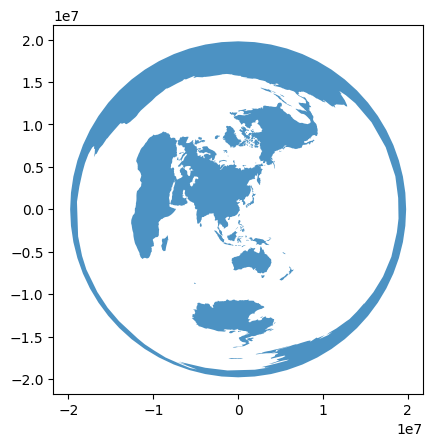

In [5]:
tmp = gdf4.copy()
k = 'N30-E120'
spg = split_geoms[k]
this_crs = projections[k]
spg = gpd.GeoDataFrame(geometry=spg)
print(spg.head())
tmp2 = tmp.overlay(spg, how='difference')


this_spg = spg.to_crs(this_crs)
tmp3 = tmp2.to_crs(this_crs)

#tmp3 = tmp2.clip(this_spg)
tmp3.plot(alpha=.8)

                                            geometry
0  POLYGON ((-61.33856 -29.99747, -61.33518 -30.0...


<Axes: >

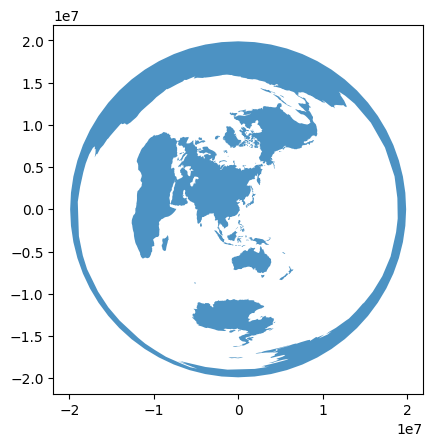

In [102]:
tmp = gdf4.copy()
k = 'N30-E120'
this_crs = projections[k]
if k in split_geoms:
    spg = split_geoms[k]
    spg = gpd.GeoDataFrame(geometry=spg)
    print(spg.head())
    tmp = tmp.overlay(spg, how='difference')


#this_spg = spg.to_crs(this_crs)
tmp = tmp.to_crs(this_crs)

#tmp3 = tmp2.clip(this_spg)
tmp.plot(alpha=.8)

<Axes: >

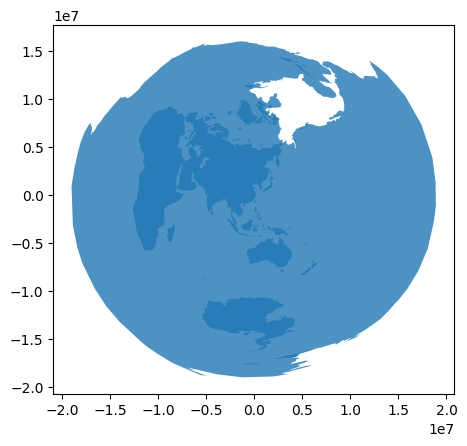

In [101]:
tmp = gdf4.copy()
k = 'N30-E120'
#spg = split_geoms[k]
this_crs = projections[k]
#spg = gpd.GeoDataFrame(geometry=spg)
#print(spg.head())
tmp2 = tmp#.overlay(spg, how='difference')


tmp3 = tmp2.to_crs(this_crs)

#tmp3 = tmp2.clip(this_spg)
tmp3.plot(alpha=.8)

<Axes: >

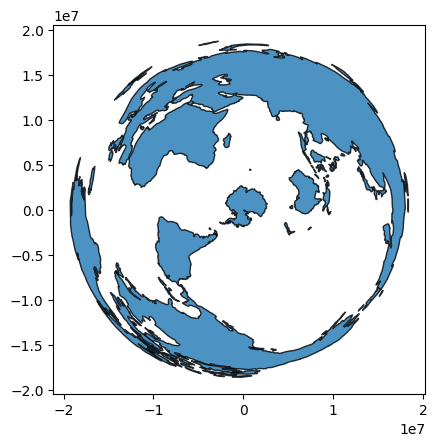

In [179]:
k = 'S90-E60'
tmp = gdf4.copy()
this_crs = projections[k]
if k in split_geoms:
    spg = split_geoms[k]
    spg = gpd.GeoDataFrame(geometry=spg)
    print(spg.head())
    tmp = tmp.overlay(spg, how='difference')


#this_spg = spg.to_crs(this_crs)
tmp = tmp.to_crs(this_crs)

#tmp3 = tmp2.clip(this_spg)
tmp.plot(alpha=.8, ec='k')

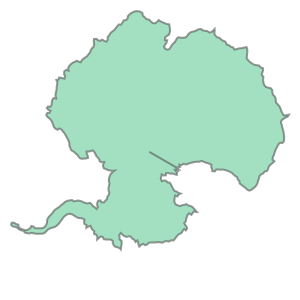

In [180]:
tmp.iloc[44].geometry

In [181]:
gdf5[gdf5['id']==44]

,id,featurecla,geometry,area,alt_x,alt_y,ref_pt
44,44,Admin-0 country,"POLYGON ((130.00000 -90.00000, 125.00000 -90.0...",5982.564063,NaN,NaN,NaN


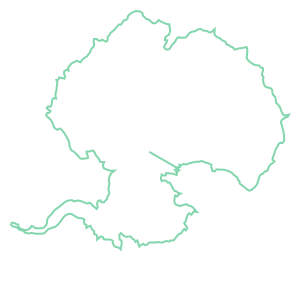

In [182]:
tmp.iloc[44].geometry.exterior

In [178]:
xxs, yys = gdf5[gdf5['id']==44].geometry.exterior.tolist()[0].xy
min(yys)

-90.0

In [ ]:
tmp = gdf4.copy()
tmp['cat'] = 9999
tmp['alt_x'] = None
tmp['alt_y'] = None

print(len(tmp))
for lon0, slines in zip(lon0s, split_lines):
for k, sp in split_geoms.items():
    
    line1, line2, line3 = slines
    tmp2 = tmp.copy()

    geoms = []
    for i in range(len(tmp2)):
        row = tmp2.iloc[i]
        poly = row['geometry']
        split_polys = split(poly, line1)
        split_polys = [p for p in split_polys.geoms]
        if len(split_polys)==1:
            gs = split_polys
            new_poly = Polygon(gs[0])
            geoms.append({'geometry': new_poly, 'cat': row['cat'], 
                          'alt_x': row['alt_x'], 'alt_y': row['alt_y']})
        else:
            #print(len(split_polys))
            gs = []
            for p in split_polys:
                tmp3 = split(p, line2)
                tmp3 = [p for p in tmp3.geoms]
                #print(len(tmp3))
                gs.extend(tmp3)
            #gs2 = []
            #gs3 = []
            for g in gs:
                if not(g.intersects(line3)):
                    #gs2.append(g)
                    new_poly = Polygon(g)
                    geoms.append({'geometry': new_poly, 'cat': -9999, 
                                  'alt_x': None, 'alt_y': None})
                else:
                    #gs3.append(g)  # need to be hidden
                    new_poly = Polygon(g)
                    left_pt = sorted([p for p in new_poly.exterior.coords])[0]
                    #print(, lon0)
                    #alt_pt = Point(left_pt)#.buffer(0.0001).exterior.coords
                    geoms.append({'geometry': new_poly, 'cat': lon0, 
                                  'alt_x': left_pt[0], 'alt_y': left_pt[1]})  
                    # hide when lon0 is the ref line
            #print(len(gs), len(gs2))
            #new_poly = MultiPolygon(gs2)
        #geoms.append(new_poly)
    #tmp2['geometry'] = geoms
    #tmp2 = tmp.explode(index_parts=False)
    tmp4 = pd.DataFrame(geoms)
    tmp4 = gpd.GeoDataFrame(tmp4, crs=gdf4.crs)
    #print(tmp4)
    #tmp4.plot()
    tmp = tmp4
    print(len(tmp))
    #break
gdf5 = tmp
gdf5 = gdf5.reset_index().rename(columns={'index': 'id'})